# DBSCAN vs DBSCRN

In [1]:
import time
import warnings
import math

from sklearn.datasets import make_blobs
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster
from sklearn import preprocessing

np.random.seed(0)

def cluster_encoder(cluster):
    le = preprocessing.LabelEncoder()
    le.fit(cluster)
    return le.transform(cluster)

# Dataset for testing

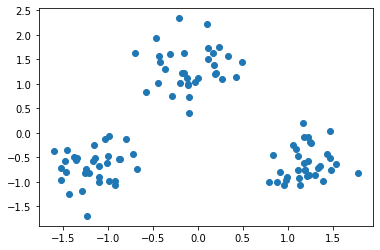

In [223]:
data, y = make_blobs(n_samples=100, centers = [(5, -5), (0, 0), (-5, -5)], cluster_std=1, n_features=2, random_state=5)
data = StandardScaler().fit_transform(data)

fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1]);

# Clusterization performance metrics

In [224]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import pairwise_distance

# n_clusters: the number of discovered clusters,
# y: real clusters,
# c: discovered clusters

# Purity
def purity(C, G):
    common_items_inclusters = metrics.cluster.contingency_matrix(C, G)
    purity_score = np.sum(np.amax(common_items_inclusters, axis=0)) / np.sum(common_items_inclusters)
    return purity_score

def evaluate(y_pred, y_true, data):
    y_pred = cluster_encoder(y_pred)
    return {
        "purity": purity(y_true, y_pred),
        "adjusted_rand_score": adjusted_rand_score(y_true, y_pred),
        "davies_bouldin_score": davies_bouldin_score(data, y_pred),
        "silhouette_score_euclidean": metrics.silhouette_score(data, y_pred, metric = 'euclidean'),
        "silhouette_score_cosine": metrics.silhouette_score(data, y_pred, metric = 'cosine'),
    }

# Distance or (dis)similarity measures 

## Euclidean similarity

In [225]:
def euclidean_distance(a, b):
    similarity_measure = 0
    for i in range(len(a)):
         similarity_measure += pow((a[i] - b[i]), 2)
    return np.sqrt(similarity_measure)

## Cosinus dissimilarity 

In [226]:
def cosine_dissimilarity(a, b):
    dot = 0
    norm_a = 0
    norm_b = 0
    for i in range(len(a)):
        dot += a[i] * b[i]
        norm_a += a[i]**2
        norm_b += b[i]**2
    return 1 - dot / (norm_a * norm_b)**0.5

# DBSCAN

## Get reachable neighbors

In [227]:
def get_neighbors(data, current_index, epsilon, similarity):
    neighbor_indices = []
    for neighbor_index, neighbor in enumerate(data):
        if similarity(neighbor, data[current_index]) <= epsilon:
            neighbor_indices.append(neighbor_index)
    return neighbor_indices

## Clusterization algorithm

In [228]:
def dbscan(data, epsilon, minPts, similarity):
    
    # each data point can be in one of 3 stages
    NOT_VISITED = 0 # not visited point
    VISTED = 1 # non-core point
    CLUSTERED = 2 # core point
    
    # initial setup
    n = data.shape[0]
    cluster = np.array([0] * n) # cluster register
    state = np.array([NOT_VISITED] * n) # state register
    cluster_id = 1

    def search(current_index, cluster_id, epsilon, minPts, similarity):
        neighbor_indices = get_neighbors(data, current_index, epsilon, similarity)
        if len(neighbor_indices) >= minPts:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in neighbor_indices:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, cluster_id, epsilon, minPts, similarity)
        else:
            state[current_index] = VISTED

    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0]
        search(not_visited_ids[0], cluster_id, epsilon, minPts, similarity)
        cluster_id += 1
    
    return cluster

## Evaluation

### Euclidean distance

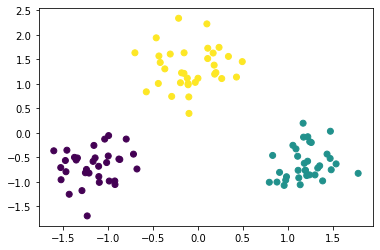

{'purity': 1.0,
 'adjusted_rand_score': 1.0,
 'davies_bouldin_score': 0.3558505657725602,
 'silhouette_score_euclidean': 0.7446693236136052,
 'silhouette_score_cosine': 0.9547976849733445}

In [230]:
y_pred = dbscan(data=data, epsilon=0.5, minPts=3, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, data)

### Cosine dissimilarity

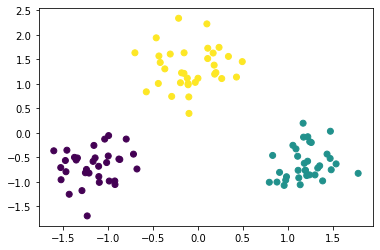

{'purity': 1.0,
 'adjusted_rand_score': 1.0,
 'davies_bouldin_score': 0.3558505657725602,
 'silhouette_score_euclidean': 0.7446693236136052,
 'silhouette_score_cosine': 0.9547976849733445}

In [231]:
y_pred = dbscan(data=data, epsilon=0.05, minPts=10, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, data)

# DBSCRN

## KNN

In [232]:
def get_knn(current_index, neighbor_indices, k, similarity):
    if current_index in neighbor_indices: neighbor_indices.remove(current_index)
    neighbor_similaritys = []
    for neighbor_index in neighbor_indices:
        similarity_measure = similarity(data[neighbor_index], data[current_index])
        neighbor_similaritys.append(similarity_measure) 
    sort_indices = np.argsort(neighbor_similaritys)
    neighbor_indices = np.array(neighbor_indices)
    return neighbor_indices[sort_indices][:k].tolist()

## RNN

In [233]:
def get_pointwise_rnn(point_knn, current_index):
    rnn = []
    for neighbor in point_knn[current_index]:
        if current_index in point_knn[neighbor]:
            rnn.append(neighbor)
    return rnn
    
def get_rnn(point_indices, k):
    point_rnn = {}
    point_knn = {}
    for current_index in point_indices:
        knn = get_knn(current_index, point_indices[:], k, similarity)
        point_knn[current_index] = knn
    for current_index in point_indices:
        rnn = get_pointwise_rnn(point_knn, current_index)
        point_rnn[current_index] = rnn
    return point_rnn

## Clusterization algorithm

In [234]:
def dbscanrn(data, k, similarity):
    
    # each data point can be in one of 3 stages
    NOT_VISITED = 0 # not visited point
    VISTED = 1 # non-core point
    CLUSTERED = 2 # core point
    
    # initial setup
    n = data.shape[0]
    cluster = np.array([0] * n) # cluster register
    state = np.array([NOT_VISITED] * n) # state register
    cluster_id = 1
    all_point_indices = list(range(len(data))) # inidces of all points
    point_rnn = get_rnn(all_point_indices, k) # calculate RNN_k for all points
    
    # search for clusters
    def search(current_index, k):
        if len(point_rnn[current_index]) < k:
                state[current_index] = VISTED
        else:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in point_rnn[current_index]:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, k)
    
    # visit all data points
    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0][0]
        search(not_visited_ids, k)
        cluster_id += 1
    
    # clusterize all outlier data points 
    while VISTED in state:
        not_clustered_ids = np.where(state==VISTED)[0][0]
        clustered_ids = np.where(state==CLUSTERED)[0]
        knn = get_knn(not_clustered_ids, clustered_ids, 1, distance)
        cluster[not_clustered_ids] = cluster[knn[0]]
        state[not_clustered_ids] = CLUSTERED
    
    return cluster

## Evaluation

### Euclidean distance

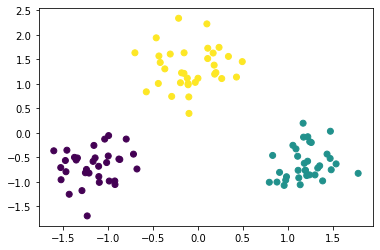

{'purity': 1.0,
 'adjusted_rand_score': 1.0,
 'davies_bouldin_score': 0.3558505657725602,
 'silhouette_score_euclidean': 0.7446693236136052,
 'silhouette_score_cosine': 0.9547976849733445}

In [235]:
y_pred = dbscanrn(data=data, k=10, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, data)

## Cosine dissimilarity

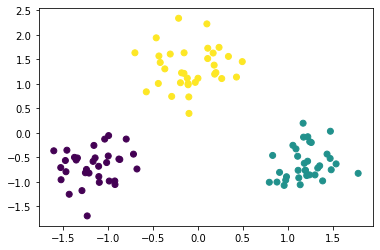

{'purity': 1.0,
 'adjusted_rand_score': 1.0,
 'davies_bouldin_score': 0.3558505657725602,
 'silhouette_score_euclidean': 0.7446693236136052,
 'silhouette_score_cosine': 0.9547976849733445}

In [236]:
y_pred = dbscanrn(data=data, k=10, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(data[:,0], data[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, data)

# Example from lecture

In [237]:
X = np.array(
    [[4.2, 4.0], 
    [5.9, 3.9],
    [2.8, 3.5],
    [12.0, 1.3],
    [10.0, 1.3],
    [1.1, 3.0],
    [0.0, 2.4],
    [2.4, 2.0],
    [11.5, 1.8],
    [11.0, 1.0],
    [0.9, 0.0],
    [1.0, 1.5]], np.single)

X = StandardScaler().fit_transform(X)

# real clusters
y =  np.array([1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1])

## DBSCANRN: euclidean distance

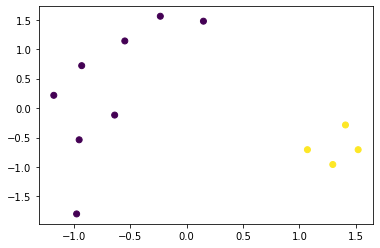

{'purity': 0.9166666666666666,
 'adjusted_rand_score': 0.7890410958904109,
 'davies_bouldin_score': 0.5802992349799708,
 'silhouette_score_euclidean': 0.5339634,
 'silhouette_score_cosine': 0.6784044}

In [239]:
y_pred = dbscan(data=X, epsilon=0.5, minPts=4, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)

## DBSCAN: cosine dissimilarity

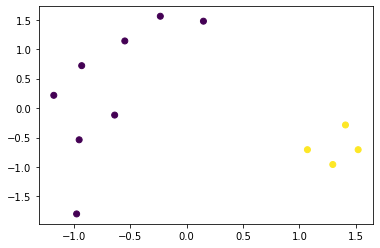

{'purity': 0.9166666666666666,
 'adjusted_rand_score': 0.7890410958904109,
 'davies_bouldin_score': 0.5802992349799708,
 'silhouette_score_euclidean': 0.5339634,
 'silhouette_score_cosine': 0.6784044}

In [240]:
y_pred = dbscan(data=X, epsilon=0.5, minPts=4, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)

## DBSCANRN: euclidean distance

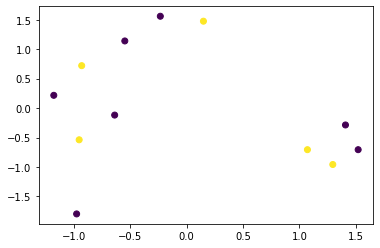

{'purity': 0.5833333333333334,
 'adjusted_rand_score': 0.019498607242339833,
 'davies_bouldin_score': 12.468419229593488,
 'silhouette_score_euclidean': -0.12486723,
 'silhouette_score_cosine': -0.13842197}

In [241]:
y_pred = dbscanrn(data=X, k=3, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)

## DBSCANRN: cosine dissimilarity

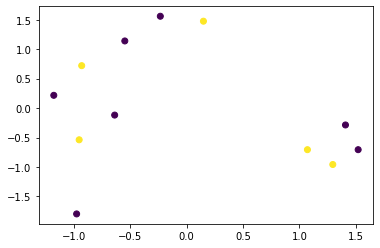

{'purity': 0.5833333333333334,
 'adjusted_rand_score': 0.019498607242339833,
 'davies_bouldin_score': 12.468419229593488,
 'silhouette_score_euclidean': -0.12486723,
 'silhouette_score_cosine': -0.13842197}

In [242]:
y_pred = dbscanrn(data=X, k=4, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)